## Reanalysis of TnSeq data

In this notebook, I verify predictions from simulated fitness assays and error estimates using data from my transposon sequencing project on the Long-term evolution experiment. Because we went overboard with sequencing depth, and had multiple timepoints in my analysis, I can downsample data or use fewer timepoints and explore how that changes error estimates. 

In addition, I performed fitness assays for the LTEE ancestor in LB (with 10 generations per day). This allows me to potentially explore whether in log2(100) generations vs 10 generations per day impacts measurement error.

In [1]:
#importing libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns
import pathlib
import os
from scipy.stats import gaussian_kde

In [2]:
sns.set_theme()
sns.set_context('paper')
sns.set_style('ticks')

#### Importing functions for reanalysis of data + additional helper functions

In [ ]:
from functions import *

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays/AnalysisNotebooks


In [4]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the fitness trajectories data
path = pathlib.Path(cwd)
repo = str(path.parents[0])
print(path.parents[0]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays


In [5]:
#paths for metadat and mutant trajectories
metadata_path = repo+'/Metadata/'
data_path = repo+'/ProcessedData/Mutant_Trajectories/'

In [6]:
#names of libraries
libraries = ['REL606']
#more interpretable names for the figures in the paper
libraries2 = ['Anc']

In [7]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

#genomic coordinates of pseudogenes
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')

In [8]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

#reading the REL606 reference genome
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in the interior of each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle of the gene, excluding defined fractions at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

### Here, I want to compare how measurement error varies with true fitness; for this calculation, I will restrict analysis to trajectories that survive to the end of the assay.

Reasoning: because we add a pseudocount for trajectories that die out at the first appearance of a zero, fitnesses for essential genes may appear more accurate than they actually are (we're basically doing log(x/1)/6.64, where x is quite similar for the TA sites within the gene)

In [9]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([len(libraries), 5, len(ta_sites)])
counts_all_red = np.zeros([len(libraries), 5, len(ta_sites)])

for k in range(len(libraries)):
    #loading the new file where I have the counts for each TA site for all time points
    gname = data_path+'green_'+libraries[k]+'_merged_all_TAsites.txt'
    greendata = np.loadtxt(gname)
    rname = data_path+'red_'+libraries[k]+'_merged_all_TAsites.txt'
    reddata = np.loadtxt(rname)
    #now for extracting the UMI corrected coutns
    counts_all_green[k,:,:] = greendata[2:11:2,:]
    counts_all_red[k,:,:] = reddata[2:11:2,:]

In [10]:
#normalized counts data for each sample:
greensum = np.sum(counts_all_green,axis=2)
redsum = np.sum(counts_all_red, axis=2)

In [15]:
#parameters for filtering out noisy data and selecting which time points to use in analysis
min_sites = 2
min_frac = 0.2
#timepoints to compare:
# change this depending on the analysis you want to do!
t0 = 0
t1 = 4
time_range = np.linspace(t0,t1,t1-t0+1)*6.64
tm1_depth = 5
max_reads = 100

### Fig 1: Error as a function of true fitness (using two timepoints only)

For this analysis, only using two timepoints of the fitness assay for showing the negative correlation between error and true fitness

In [18]:
fitness_inverse_var_2, pop_error_inv_2 = fitness_estimate(counts_all_green[0], counts_all_red[0], 
                                                           genes_lost=np.zeros(len(names)), locs=locations, initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=max_reads,
                                                           min_sites=min_sites, t_start=0, t_end=1)

In [19]:
genes_analyze = np.where(np.mean(fitness_inverse_var_2,axis=1) > -0.5)[0]
linreg = stats.linregress(np.mean(fitness_inverse_var_2[genes_analyze],axis=1), pop_error_inv_2[genes_analyze])

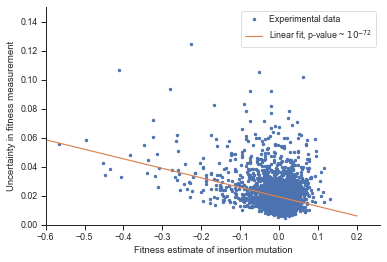

In [20]:
x_range = np.linspace(-0.6, 0.2, 100)
plt.plot(np.mean(fitness_inverse_var_2,axis=1), pop_error_inv_2, '.', label='Experimental data')
plt.plot(x_range, x_range*linreg.slope+linreg.intercept, label='Linear fit, p-value ~ $ 10^{-72}$')
plt.xlabel('Fitness estimate of insertion mutation')
plt.ylabel('Uncertainty in fitness measurement')
plt.legend()
plt.xlim(-0.6)
plt.ylim(0, 0.15)
sns.despine()

In [21]:
print('p-value of linear regression', linreg.pvalue)

p-value of linear regression 1.241671638276303e-72


In [22]:
bins = [-0.6, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05]
error_mean = np.zeros(7)
genes_per_bin = np.zeros(7)
for i in range(len(error_mean)):
    fitness_range = np.mean(fitness_inverse_var_2,axis=1)
    genes_select = np.where((fitness_range>bins[i])&(fitness_range<bins[i+1]))[0]
    error_mean[i] = np.mean(pop_error_inv_2[genes_select])
    genes_per_bin[i] = len(genes_select)

In [23]:
genes_per_bin

array([  27.,   13.,   32.,   55.,  175., 1261., 1613.])

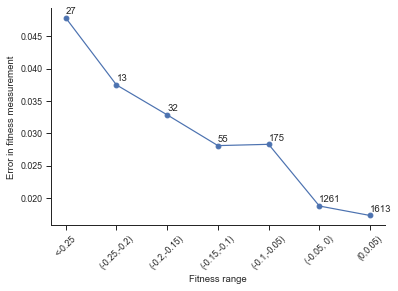

In [34]:
labels = ['<-0.25', '(-0.25,-0.2)', '(-0.2,-0.15)', '(-0.15,-0.1)', '(-0.1,-0.05)', '(-0.05, 0)', '(0,0.05)']
plt.plot(labels, error_mean, marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel('Fitness range')
plt.ylabel('Error in fitness measurement')
for i, descr in enumerate(genes_per_bin):
    plt.annotate(int(descr), (labels[i], error_mean[i] + 0.0006))
sns.despine()
plt.show()

c,d) Combining both of these panels into a single output file for the second half of Figure 1. 

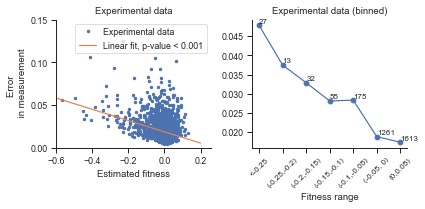

In [63]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=False)
    
    ax[0].plot(np.mean(fitness_inverse_var_2,axis=1), pop_error_inv_2, '.', label='Experimental data')
    ax[0].plot(x_range, x_range*linreg.slope+linreg.intercept, label='Linear fit, p-value < 0.001')
    ax[0].set(xlabel='Estimated fitness', ylabel='Error \n in measurement', xlim=(-0.6), ylim=(0,0.15),
             title='Experimental data')
    ax[0].locator_params(axis='y', nbins=5)
    ax[0].legend(loc=0)
    ax[1].plot(labels, error_mean, marker='o', linestyle='-')
    ax[1].set(xlabel='Fitness range', title='Experimental data (binned)')
    ax[1].tick_params(axis='x', which='both', labelrotation = 45, labelsize=8) 
    for i, descr in enumerate(genes_per_bin):
        ax[1].annotate(int(descr), (labels[i], error_mean[i] + 0.0006), fontsize=8)
    fig.tight_layout()
    sns.despine()
    fig.savefig('./Figures/measurement_uncertainty_reanalysis.pdf', format='pdf', bbox_inches='tight')


### Fig 2: Impact of experimental parameters on near-neutral fitness estimates

- sequencing depth: downsample upto a factor of 1:100
- number of bottlenecks: two to five timepoints?

Other params:
- for reanalysis, consider genes within 5% of neutrality as neutral

While doing the reanalysis, I'm also extracting information on the ten most deleterious fitness effects detected from the data. This will be needed in Figure 4.

In [45]:
scaling_range = 1/np.logspace(-2,0,9)
days_range = np.linspace(2,5,4).astype('int')
s_neut = 0.05

In [46]:
#matrix for storing the error data
error_scaling_days = np.zeros([len(scaling_range),len(days_range)])
most_del = np.zeros([len(scaling_range),len(days_range)])

In [47]:
for i in range(len(scaling_range)):
    scale = scaling_range[i]
    scaled_data_red = downsample(counts_all_red[0], scale)
    scaled_data_green = downsample(counts_all_green[0], scale)
    for j in range(len(days_range)):
        days = days_range[j]
        #now run the fitness calculator function;
        #an important parameter is initial_depth: should be somewhat scaling with total coverage, but set a minimum
        #my approach:
        fitnesses, errors = fitness_estimate(scaled_data_green, scaled_data_red, 
                                             genes_lost=np.zeros(len(names)), locs=locations, 
                                             initial_depth=2,
                                             min_frac=0.1,max_reads=max_reads,
                                             min_sites=1, t_start=0, t_end=days-1)
        #slicing data only for neutral genes
        neutral = np.where(np.abs(np.mean(fitnesses, axis=1))<s_neut)[0]
        error_scaling_days[i,j] = np.mean(errors[neutral])
        #most deleterious mutations
        most_del[i,j] = np.mean(np.sort(np.mean(fitnesses, axis=1)[np.mean(fitnesses, axis=1)>-1])[:10])

In [48]:
np.mean(np.sort(np.mean(fitnesses, axis=1)[np.mean(fitnesses, axis=1)>-1])[:10]

-0.14031320529147623

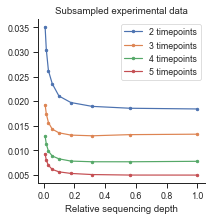

In [62]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(days_range)):
        ax.plot(1/scaling_range[:], error_scaling_days[:, i], '.-', label=f'{days_range[i]} timepoints')
        ax.set_xlabel('Relative sequencing depth')
        ax.set_title('Subsampled experimental data')
    plt.legend(loc=0)
    sns.despine()
    plt.show()
    fig.savefig('./Figures/neutral_muts_reanalyzed_d.pdf', format='pdf', bbox_inches='tight')

Discuss with Michael how to make this figure work

### Fig 5: Resolution of deleterious fitness effects depends on the sequencing depth and number of bottlenecks

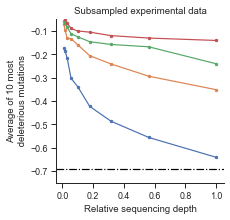

In [61]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(days_range)):
        ax.plot(1/scaling_range, most_del[:, i], '.-', label=f'{days_range[i]} timepoints')
        ax.set_xlabel('Relative sequencing depth')
        ax.set_ylabel('Average of 10 most\n deleterious mutations')
    ax.axhline(-np.log(2), color='black', label='Fitness of \nunviable strain', linestyle='-.')
#     ax.legend(loc=0)
    ax.set_ylim(-0.75, -0.05)
    ax.set(title='Subsampled experimental data')
    sns.despine()
    plt.show()
    fig.savefig('./Figures/most_deleterious.pdf', format='pdf', bbox_inches='tight')